In [6]:
import hmf
from hmf import mass_function
from astropy.cosmology import FlatLambdaCDM

import numpy as np
import astropy.constants as con
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
# define matplotlib style
matplotlib.style.use('classic')
matplotlib.rc('xtick.major', size=15, width=2)
matplotlib.rc('xtick.minor', size=9 , width=2)
matplotlib.rc('ytick.major', size=15, width=2)
matplotlib.rc('ytick.minor', size=9 , width=2)
matplotlib.rc('lines',linewidth=2, markersize=20)
matplotlib.rc('axes', linewidth=2)

#matplotlib.rc('text', usetex=True)
matplotlib.rc('font',**{'family':'STIXGeneral'})
matplotlib.rc('mathtext', fontset='stix')

import obdata_loader as ob

In [2]:
# define cosmology; Planck collaboration 2020
hubble  = 0.6732   
Omega0  = 0.3158 
ns      = 0.96605
sigma8  = 0.8120
fbaryon = 0.156

cosmo = FlatLambdaCDM(H0=hubble*100, Om0 = Omega0, Ob0=Omega0*fbaryon, Tcmb0=2.7255, Neff=3.046, m_nu=0.0)

In [3]:
def calculate_hmf_kmaxextra(z, Mmin, Mmax, dlog10m, cosmo):
        halo_mass_function = mass_function.hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, dlog10m=dlog10m, 
                cosmo_model=cosmo, n = ns, sigma_8 = sigma8, delta_c=1.686, 
                # transfer function defaults to CAMB
                transfer_model = hmf.density_field.transfer_models.CAMB, transfer_params = {"extrapolate_with_eh":True},
                hmf_model      = hmf.mass_function.fitting_functions.Tinker10, hmf_params=None, 
                mdef_model     = hmf.halos.mass_definitions.SOVirial, mdef_params=None, 
                filter_model   = hmf.density_field.filters.TopHat, filter_params=None)

        hubble = cosmo.H0.value/100 

        mhalo_arr    = np.arange(Mmin, Mmax, dlog10m) - np.log10(hubble)    # log10(M[Msun])
        phi_halo_arr = halo_mass_function.dndlog10m  * hubble**3            # dn/dlog10M [1/Mpc^3/dex]
        return mhalo_arr, phi_halo_arr

In [4]:
def star_formation_efficiency_fiducial(mhalo):
    # our adaptation of the double power law model 
    return 0.5 * 6.4e-2 / ( (mhalo/10**(12.0))**0.5 + (mhalo/10**(12.0))**(-0.6) ) / fbaryon

# halo accretion models
def halo_accretion_rate(mhalo, redshift):
    # Fakhouri 2010
    # Mhalo in Msun
    #mhalo_dot = 46.1 * (1 + 1.11*redshift) * np.sqrt(Omega0*(1+redshift)**3 + (1-Omega0))  \
    # * (mhalo / 1e12)**(1.1)
    mhalo_dot = 25.3 * (1 + 1.65*redshift) * np.sqrt(Omega0*(1+redshift)**3 + (1-Omega0))  \
     * (mhalo / 1e12)**(1.1)
    #corr = 10**(-0.1) # down 0.1 dex consider the drop of sigma8
    return mhalo_dot 

# SFR and Luv conversion models
def convert_sfr_to_Muv(sfr, model='Madau2014'):
    if model == 'Kennicutt2012':
        logCx = 43.35 # Kennicutt & Evans 2012 (assuming Kroupa IMF; using STARBURST99; solar metallicity)
        logLx = np.log10(sfr) + logCx  # log Lx in erg/s
        fnu = 10**logLx / (4*np.pi* (10*con.pc.value*100)**2 ) / (con.c.value/(1500*1e-10))
        Muv = -2.5 * np.log10(fnu) - 48.6 # AB mag
    elif model == "Madau2014":
        fnu = (sfr / 1.15e-28)/ (4*np.pi* (10*con.pc.value*100)**2 ) # erg/s/Hz/cm^2
        Muv = -2.5 * np.log10(fnu) - 48.6 # AB mag
    return Muv

# dust attenuation models
def dust_attenuation(muv, dust_norm = "fixed"):
    # muv: intrinsic UV magnitude
    k_softplus = 10
    if dust_norm == "fixed":
        C0, C1 = 4.43, 1.99  # IRX beta relation, M99
        slope = -0.17; Mref = -19.5; intercept = -2.085 # Cullen 2023
        scatter = 0 # for a median relation
        #scatter=0.35 # for a mean relation

        prefactor = 1/(1 - C1 * slope)
        muv_obs = prefactor * (  muv  + C0 + C1 * intercept - C1 * slope * Mref + 0.2 * np.log(10) * C1**2 * scatter**2  )    # Vogelsberger 2020
        #return muv_obs * (muv_obs >= muv) + muv * (muv_obs < muv)
        return 1/k_softplus * np.log(1 + np.exp( k_softplus *( muv_obs - muv) )) + muv
    else:
        A = 1/(1 - 1.99 * (-0.17)) - 1 # Vogelsberger 2020
        B = dust_norm
        Auv = A * (muv - (-21)) + B
        muv_obs = muv + Auv
        #return muv_obs * (muv_obs >= muv) + muv * (muv_obs < muv)
        return 1/k_softplus * np.log(1 + np.exp( k_softplus *( muv_obs - muv) )) + muv    

In [5]:
def mapfunc_mhalo_to_muv(log_mhalo, epsilon=0.02, redshift=10, dust_norm = "fixed", include_dust=True):
    '''
    mapping from halo mass to UV magnitude (without scatter)
    muv: UV magnitude
    log_mhalo: log10 of halo mass in Msun
    '''
    if type(epsilon) == str:
        if epsilon == "this_work":
            epsilon = star_formation_efficiency_fiducial(10**log_mhalo)
        elif "vary" in epsilon: # e.g. "vary_0.01"
            fcorr = float(epsilon.split("_")[1])
            epsilon = star_formation_efficiency_fiducial(10**log_mhalo) * fcorr

    sfr = epsilon * fbaryon * halo_accretion_rate(10**log_mhalo, redshift=redshift)
    muv_raw = convert_sfr_to_Muv(sfr)
    if include_dust:
        muv = dust_attenuation(muv_raw, dust_norm=dust_norm)
    else:
        muv = muv_raw
    return muv

def mapfunc_jacobian_numeric(log_mhalo, **kwargs):
    # return dMuv/dlogMhalo numerically
    # compute the derivative of muv with respect to mhalo
    dlogm=0.001
    muv_plus = mapfunc_mhalo_to_muv(log_mhalo + dlogm, **kwargs)
    muv_minus = mapfunc_mhalo_to_muv(log_mhalo - dlogm, **kwargs)
    dmuv_dlogm = (muv_plus - muv_minus) / (2*dlogm)
    return np.abs(dmuv_dlogm)

def convolve_on_grid(input_grid, input_weight, sigma_uv):
    # convolve with a gaussian kernel
    # over the UV luminosity function
    grid_binsize  = input_grid[1] - input_grid[0]
    minimum_sigma = grid_binsize/4. # set to the binsize divided by a constant
    sigma_uv = max(sigma_uv, minimum_sigma) # regulate the miminum sigma to be of order the binsize (~ 0.01 dex)

    output_weight = np.zeros(len(input_grid))
    for i, mapfrom in enumerate(input_grid):
        raw_output    = np.zeros(len(input_grid))
        for j, mapto in enumerate(input_grid):
            raw_output[j] += 1./np.sqrt(2*np.pi*sigma_uv**2) * np.exp( -0.5 * (mapto - mapfrom)**2 / sigma_uv**2 )
        sum_raw_output = np.sum(raw_output)
        if sum_raw_output > 0:
            raw_output = raw_output/sum_raw_output
        else:
            raw_output = np.zeros(len(input_grid))
        output_weight += input_weight[i] * raw_output
    return output_weight

#########
def compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, sigma_uv, dust_norm="fixed", epsilon=0.02, redshift=10, include_dust=True):
    # mhalo_arr: log10(Mhalo/Msun)
    # phi_halo_arr: dn/dlog10Mhalo
    # compute the UV luminosity function from the halo mass function
    muv_arr    = mapfunc_mhalo_to_muv(     mhalo_arr, epsilon=epsilon, redshift=redshift, dust_norm = dust_norm, include_dust=include_dust)
    dmuv_dlogm = mapfunc_jacobian_numeric( mhalo_arr, epsilon=epsilon, redshift=redshift, dust_norm = dust_norm, include_dust=include_dust)
    if sigma_uv > 0: phi_uv_arr = convolve_on_grid(muv_arr, phi_halo_arr/dmuv_dlogm , sigma_uv = sigma_uv)
    else:            phi_uv_arr = phi_halo_arr/dmuv_dlogm
    #print(phi_uv_arr)
    return muv_arr, phi_uv_arr

In [120]:
np.random.seed(1234)

# define the sampling approach
def sample_from_hmf(mhalo_arr, phi_halo_arr, redshift, case, N=10000):
    # N: number of samples to draw
    logmhalo_min, logmhalo_max = np.min(mhalo_arr), np.max(mhalo_arr) 

    logm = np.random.rand(N) * (logmhalo_max - logmhalo_min) + logmhalo_min
    weights = interp1d(mhalo_arr, phi_halo_arr, kind='linear', fill_value="extrapolate")(logm)
    weights = weights/ (N/(logmhalo_max - logmhalo_min))

    shalo, ssf, sdust = 0.3, 0.3, 0.28 * 2.5
    if case == "min":
        dlogmdot = np.random.normal(0, shalo, N) 
        dlogsfe  = 0
        dAuv     = 0
    elif case == "corr":
        dlogmdot = np.random.normal(0, shalo, N) 
        dlogsfe  = dlogmdot.copy()
        dAuv     = dlogmdot.copy() * (-sdust/shalo)
    elif case == "anticorr":
        dlogmdot = np.random.normal(0, shalo, N) 
        dlogsfe  = dlogmdot.copy()
        dAuv     = dlogmdot.copy() * (sdust/shalo)
    elif case == "indep":
        dlogmdot = np.random.normal(0, shalo, N) 
        dlogsfe  = np.random.normal(0, ssf, N)
        dAuv     = np.random.normal(0, sdust, N)
    elif case == "linear":
        dlogmdot = 0
        dlogsfe  = 0
        dAuv     = np.random.normal(0, 1, N)

    logsfe  = np.log10( star_formation_efficiency_fiducial(10**logm) )
    logmdot = np.log10( fbaryon * halo_accretion_rate(10**logm, redshift=redshift) )

    logsfr = logsfe + logmdot + dlogsfe + dlogmdot
    muv_raw = convert_sfr_to_Muv(10**logsfr)
    muv = dust_attenuation(muv_raw, dust_norm="fixed") + dAuv
    #muv = muv_raw + dAuv

    return muv, weights

def measure_uvlf(muv, weights):
    muv_grid = np.linspace(-26, -10, 100)
    muv_grid_center = (muv_grid[1:] + muv_grid[:-1])/2.
    dmuv = muv_grid[1] - muv_grid[0]

    num, _ = np.histogram(muv, bins=muv_grid, weights=weights)
    return muv_grid_center, num/dmuv

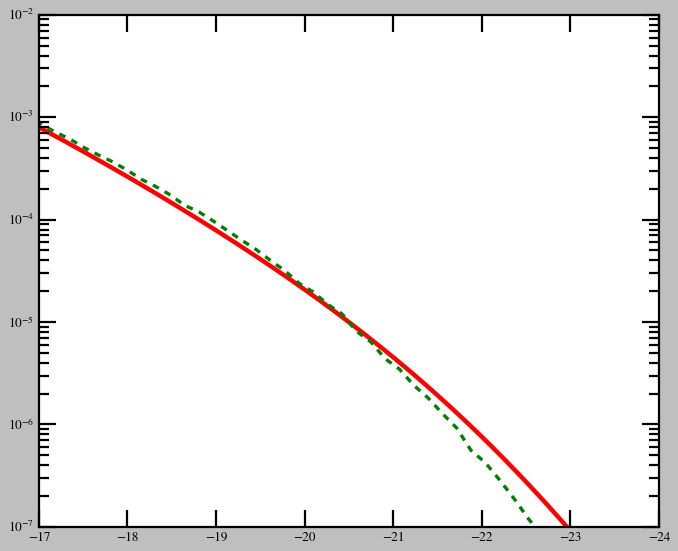

In [126]:
redshift = 10
mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=8, Mmax=17, dlog10m = 0.01, cosmo=cosmo)
xref, yref = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                        sigma_uv = 1.2, epsilon="this_work", redshift=redshift, include_dust=True)

# a test for convolution
plt.figure(figsize=(10, 8))
#x = convert_sfr_to_Muv(0.05*fbaryon*halo_accretion_rate(10**mhalo_arr, redshift=redshift))
#plt.plot(x, phi_halo_arr/(2.5*1.1), c='b', lw=4)
plt.plot(xref,yref, c='r', linestyle='-', lw=4)

#muv, weights = sample_from_hmf(mhalo_arr, phi_halo_arr, case="indep", redshift=redshift, N=10000)
#x,y = measure_uvlf(muv, weights)
#plt.plot(x, y, c='b', linestyle='--', lw=1)

muv, weights = sample_from_hmf(mhalo_arr, phi_halo_arr, case="indep", redshift=redshift, N=3000000)
x,y = measure_uvlf(muv, weights)
plt.plot(x, y, c='g', linestyle='--', lw=3)

plt.yscale('log'); plt.xlim(-17, -24); plt.ylim(1e-7, 1e-2)
plt.show()

## Best Fits
### indep:  1.2 mag 
### corr :  2.2 mag
### anticorr: 0.4 mag
### min  :  0.6 mag (with dust)  0.75 (no dust)

In [62]:
def compute_cumulative_uv_luminosity(muv_arr, phi_uv_arr, mlim_lum = -29):
    """
    Compute the cumulative UV luminosity
    assuming the Muv grid is uniform
    """
    dmuv = np.abs(muv_arr[1] - muv_arr[0]) # a constant
    Luv = 10**((muv_arr + 48.6)/(-2.5)) * 4*np.pi* (10*con.pc.value*100)**2  # erg/s/Hz
    cum_rho_uv_arr = np.zeros(len(phi_uv_arr))
    for i in range(len(phi_uv_arr)):
        select = (muv_arr[i:] > mlim_lum)
        cum_rho_uv_arr[i] = np.sum( (phi_uv_arr[i:] * Luv[i:])[select]  ) * dmuv
    return cum_rho_uv_arr # [#erg/s/Hz/Mpc^3]

def compute_total_uv_luminosity(muv_arr, phi_uv_arr, mlim = -17):
    """
    Compute the total UV luminosity
    assuming the Muv grid is uniform
    """
    dmuv = np.abs(muv_arr[1] - muv_arr[0]) # a constant
    select = (muv_arr < mlim) & (muv_arr > -29)
    Luv = 10**((muv_arr + 48.6)/(-2.5)) * 4*np.pi* (10*con.pc.value*100)**2  # erg/s/Hz
    return np.sum(phi_uv_arr[select] * Luv[select]) * dmuv # [#erg/s/Hz/Mpc^3]

def compute_cumulative_uv_count(muv_arr, phi_uv_arr):
    """
    Compute the cumulative UV count
    assuming the Muv grid is uniform
    """
    dmuv = np.abs(muv_arr[1] - muv_arr[0]) # a constant
    cum_phi_uv_arr = np.zeros(len(phi_uv_arr))
    for i in range(len(phi_uv_arr)):
        select = (muv_arr[i:] > -28)
        cum_phi_uv_arr[i] = np.sum(phi_uv_arr[i:][select]) * dmuv
    return cum_phi_uv_arr # [#/Mpc^3]

def compute_total_uv_count(muv_arr, phi_uv_arr):
    """
    Compute the total UV luminosity
    assuming the Muv grid is uniform
    """
    dmuv = np.abs(muv_arr[1] - muv_arr[0]) # a constant
    select = (muv_arr < -12) & (muv_arr > -28)
    return np.sum(phi_uv_arr[select]) * dmuv # [#/Mpc^3]

def compute_mean_shift(sigma, sigma_ref=1):
    #sigma is in unit of mag
    # shift in mean of a log-normal distribution
    sigmaL      = sigma/2.5
    sigmaL_ref  = sigma_ref/2.5
    meanX     = np.exp(( sigmaL * np.log(10) )**2 / 2.)
    meanX_ref = np.exp(( sigmaL_ref * np.log(10) )**2 / 2.)
    return 2.5 * np.log10(meanX/meanX_ref)

#print(compute_mean_shift(np.array([1,2,3,4])))

In [63]:
def load_harikane2023_specz(redshift, type=0):
    """
    Load the data from Harikane et al. 2023 
    """
    f = np.genfromtxt('observational_data/Harikane2023_Specz.dat', names=True, delimiter=',')
    select = (f['z'] == redshift) & (f['type'] == type)
    log_density = np.log10(f['density'][select])
    density_lower = np.array([max(1e-10, x) for x in (f['density'][select] - f['lower_err'][select])])

    log_lower_err = log_density - np.log10(density_lower)
    log_upper_err = np.log10(f['density'][select] + f['upper_err'][select]) - log_density

    return f['ABmag'][select], log_density, log_lower_err, log_upper_err

def plot_specz_constraints(redshift, ax=None, **kwargs):
    x,y,ylo,yup = load_harikane2023_specz(redshift=redshift, type=0)
    ax.errorbar( x, y, yerr=(ylo, yup), **kwargs)
    x,y,ylo,yup = load_harikane2023_specz(redshift=redshift, type=1)
    ax.errorbar( x, y, yerr=(ylo, yup), lolims=True, **kwargs)
    ax.errorbar( x, y, yerr=(ylo, yup), **kwargs)
    x,y,ylo,yup = load_harikane2023_specz(redshift=redshift, type=2)
    ylo = np.array([0.3 for t in ylo if t==0])
    ax.errorbar( x, y, yerr=(ylo, yup), uplims=True, **kwargs)
    ax.errorbar( x, y, yerr=(ylo, yup), **kwargs)


def load_harikane_2023_photoz_digit(redshift):
    """
    Load the data from Harikane et al. 2023 
    """
    f = np.genfromtxt('observational_data/Harikane2023_Photoz_digit.dat', names=True)
    select = (f['z'] == redshift)
    log_phi_err = (f["logPhi"][select] - f["lo"][select],  f["hi"][select] - f["logPhi"][select])
    mag_err     = (f["ABmag"][select] - f["left"][select],  f["right"][select] - f["ABmag"][select])

    return f['ABmag'][select], f["logPhi"][select], mag_err, log_phi_err

def plot_photoz_constraints(redshift, ax=None, **kwargs):
    basepath = "./observational_data/UVLF_photoz/"

    ########################################################
    f = np.genfromtxt(basepath + "Bouwens2021+Oesch2018.dat" , names=True)
    sel = (f['z'] == redshift) & (f['Phi'] - f['dPhi'] > 0)
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])  
    yup = np.log10(f['Phi'][sel] + f['dPhi'][sel])  
    ylo = np.log10(f['Phi'][sel] - f['dPhi'][sel])
    ax.errorbar(x, y, yerr=(y-ylo, yup-y), **kwargs)

    sel = (f['z'] == redshift) & (f['Phi'] - f['dPhi'] == 0)
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])  
    yup = np.log10(f['Phi'][sel] + f['dPhi'][sel]) 
    ax.errorbar(x, y, yerr=(0.3 * np.ones(len(y)), yup-y), uplims=True, **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Bowler2020.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ylo = np.log10(f['Phi'][sel] - f['lo'][sel])
    ax.errorbar(x, y, xerr=f['dMuv'][sel], yerr=(y-ylo, yup-y), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Castellano2023.dat" , names=True)
    sel = (f['z'] == redshift) & (f['type'] == 0)
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ylo = np.log10(f['Phi'][sel] - f['lo'][sel])
    ax.errorbar(x, y, xerr=f['dMuv'][sel], yerr=(y-ylo, yup-y), **kwargs)

    sel = (f['z'] == redshift) & (f['type'] == 2)
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ax.errorbar(x, y, xerr=f['dMuv'][sel], yerr=(0.3*np.ones(len(y)), yup-y), uplims=True, **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Donnan2023.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ylo = np.log10(f['Phi'][sel] - f['lo'][sel])
    ax.errorbar(x, y, xerr=f['dMuv2'][sel]/2., yerr=(y-ylo, yup-y), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Finkelstein2022a.dat" , names=True)
    if redshift == 10:
        y = np.log10(f['Phi'])
        yup = np.log10(f['Phi'] + f['up']); ylo = np.log10(f['Phi'] - f['lo'])
        ax.fill_between(f['Muv'], ylo, yup, color='gray', edgecolor='gray', alpha=0.5)

    ########################################################
    f = np.genfromtxt(basepath + "Finkelstein2022b.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ylo = np.log10(f['Phi'][sel] - f['lo'][sel])
    ax.errorbar(x, y, yerr=(y-ylo, yup-y), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Harikane2022.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ylo = np.log10(f['Phi'][sel] - f['lo'][sel])
    ax.errorbar(x, y, xerr=f['dMuv'][sel], yerr=(y-ylo, yup-y), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Harikane2023.dat" , names=True)
    sel = (f['z'] == redshift) & (f['type'] == 0)
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ylo = np.log10(f['Phi'][sel] - f['lo'][sel])
    ax.errorbar(x, y, xerr=f['dMuv'][sel], yerr=(y-ylo, yup-y), **kwargs)

    sel = (f['z'] == redshift) & (f['type'] == 2)
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ax.errorbar(x, y, xerr=f['dMuv'][sel], yerr=(0.3*np.ones(len(y)), yup-y), uplims=True, **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "McLeod2016.dat" , names=True)
    sel = f['z'] == redshift
    x=f['Muv'][sel]; y=f['logPhi'][sel]
    yup = f['up'][sel]; ylo = f['lo'][sel] 
    xl  = f['left'][sel]; xr = f['right'][sel]
    ax.errorbar(x, y, xerr=(x-xl, xr-x), yerr=(y-ylo, yup-y), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Morishita2018+2023.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y=f['logPhi'][sel]; dyup=f['up'][sel]; dylo=f['lo'][sel]
    ax.errorbar(x, y, yerr=(dylo, dyup), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Naidu2023.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y=f['logPhi'][sel]; dyup=f['up'][sel]; dylo=f['lo'][sel]
    ax.errorbar(x, y, xerr=f["dMuv"][sel], yerr=(dylo, dyup), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Perez2023.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y=f['logPhi'][sel]; dyup=f['up'][sel]; dylo=f['lo'][sel]
    ax.errorbar(x, y, yerr=(dylo, dyup), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "Stefanon2019.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['up'][sel])
    ylo = np.log10(f['Phi'][sel] - f['lo'][sel])
    ax.errorbar(x, y, yerr=(y-ylo, yup-y), **kwargs)

    ########################################################
    f = np.genfromtxt(basepath + "McLeod2023.dat" , names=True)
    sel = f['z'] == redshift
    x = f['Muv'][sel]; y = np.log10(f['Phi'][sel])
    yup = np.log10(f['Phi'][sel] + f['dPhi'][sel])
    ylo = np.log10(f['Phi'][sel] - f['dPhi'][sel])
    ax.errorbar(x, y, yerr=(y-ylo, yup-y), **kwargs)
    

In [64]:
colorlist_default = ["#fed976", "#fd8d3c", "#e31a1c", "#800026"]

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/196295726.py:35: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/196295726.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3)#, label=r"$\sigma_{\rm UV} = 0$")
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/196295726.py:54: RuntimeWarning: divide by zero encountered in log10
  plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2, zorder=-9)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/196295726.py:56: RuntimeWarning: divide by zero encountered in log10
  id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]


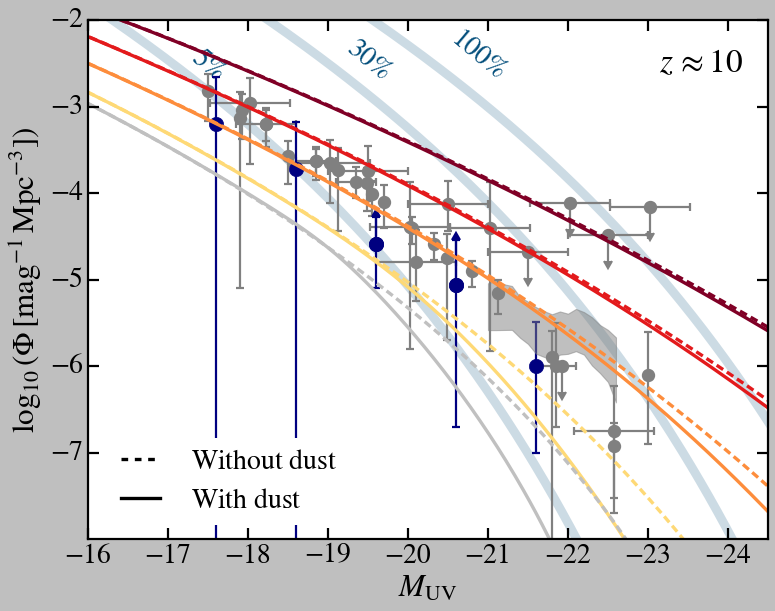

In [164]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 10
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, cosmo=cosmo)
epsilon = "this_work" #"H22_z7" 

'''
# compute reference luminosities
muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)    
luv_ref_nodust = compute_total_uv_luminosity(muv_arr, phi_uv_arr)

muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=True)    
luv_ref_dust = compute_total_uv_luminosity(muv_arr, phi_uv_arr)
'''

colors = colorlist_default
for i, sigma in enumerate([0.75, 1.5, 2, 2.5]):
    magshift = 0#compute_mean_shift(sigma) 
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, include_dust=False)    
    #luv = compute_total_uv_luminosity(muv_arr, phi_uv_arr)               
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3, linestyle="--", dashes=(7,4))

    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)  
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3)#, label=r"$\sigma_{\rm UV} = %.1f$" % sigma)

# no scatter case 
muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)                  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))

muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3)#, label=r"$\sigma_{\rm UV} = 0$")

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -7}
plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

##
for epsilon, color in zip([0.05, 0.3, 1],
                          ["#034e7b","#034e7b","#034e7b"]):
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                          sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)     
    plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2, zorder=-9) 
             #label=r"$\sigma_{\rm UV} = {%.0f},\,\,\epsilon={%d}\%%$" % (0, epsilon*100))
    id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]
    plt.text( muv_arr[id] + 0.1, np.log10(phi_uv_arr[id]), f"{epsilon*100:.0f}%", 
             fontsize=25, color=color, rotation=-40, zorder=-10)

plt.plot([],[],'--', c='k', lw=3, label=r"$\rm Without\,\,dust$")
plt.plot([],[],'-' , c='k', lw=3, label=r"$\rm With\,\,dust$")

leg = plt.legend(fontsize=25, loc=3, frameon=True, framealpha=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\,\approx{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")
#plt.show()

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2631352072.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2631352072.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3, label=r"$\sigma_{\rm UV} = 0$")
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2631352072.py:46: RuntimeWarning: divide by zero encountered in log10
  plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2631352072.py:48: RuntimeWarning: divide by zero encountered in log10
  id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]


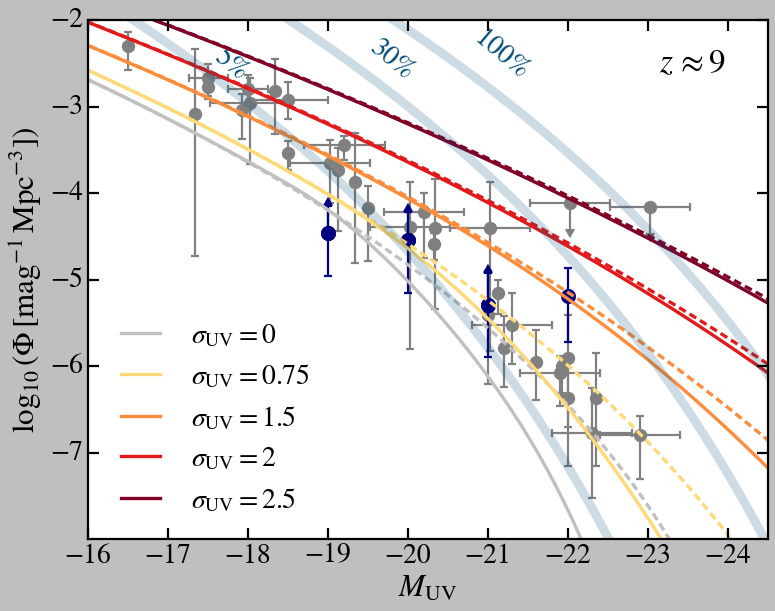

In [163]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 9
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, cosmo=cosmo)
epsilon = "this_work" #"H22_z7" 

# no scatter case 
muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)                  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))

muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3, label=r"$\sigma_{\rm UV} = 0$")
##

colors = colorlist_default
for i, sigma in enumerate([0.75, 1.5, 2, 2.5]):
    if i==0: label = r"$\sigma_{\rm UV} = %.2f$" % sigma
    elif i==2: label = r"$\sigma_{\rm UV} = %d$" % sigma
    else: label = r"$\sigma_{\rm UV} = %.1f$" % sigma
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, include_dust=False)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3, linestyle="--", dashes=(7,4))

    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3, label=label)


kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -7}
plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

##
for epsilon, color in zip([0.05, 0.3, 1],
                          ["#034e7b","#034e7b","#034e7b"]):
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                          sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)     
    plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2) 
             #label=r"$\sigma_{\rm UV} = {%.0f},\,\,\epsilon={%d}\%%$" % (0, epsilon*100))
    id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]
    if muv_arr[id] + 0.1 < -16.5:
        plt.text( muv_arr[id] + 0.1, np.log10(phi_uv_arr[id]), f"{epsilon*100:.0f}%", fontsize=25, color=color, rotation=-40, zorder=-1)

#plt.plot([],[],'--', c='gray', lw=1.5, label=r"$\rm without\,\,dust$")
#plt.plot([],[],'-' , c='gray', lw=1.5, label=r"$\rm with\,\,dust$")

leg = plt.legend(fontsize=25, loc=3, frameon=False)#, framealpha=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\,\approx{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

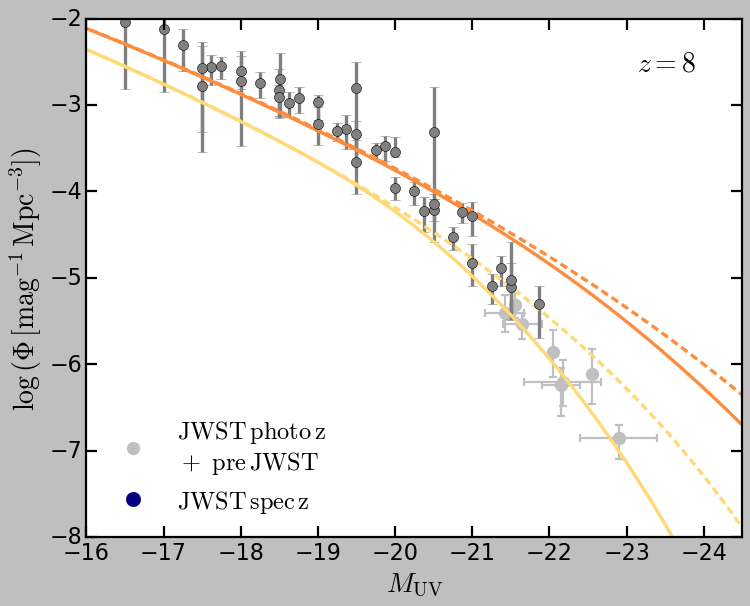

In [103]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.82, 0.81])

##just for comparison at z<=8
def mv2020_plt_obdata(fname,papername,color,label=True):
	obdataPath = "observational_data/obdata_MV2020_archived/"
	obdata=np.genfromtxt(obdataPath+fname,names=True, comments='#')
	x_ob=obdata['m']
	phi=obdata['phi']
	id1=phi>0
	id2= (phi<=0)
	y_ob=0.0*x_ob
	y_ob[id1]=np.log10(phi[id1])
	y_ob[id2]=phi[id2]
	uperr=0.0*x_ob
	uperr[id1]=np.log10(phi[id1]+obdata['uperr'][id1])-y_ob[id1]
	uperr[id2]=obdata['uperr'][id2]
	low=phi-obdata['lowerr']
	low[low<=0]=1e-10
	lowerr=0.0*x_ob
	lowerr[id1]=-np.log10(low[id1])+y_ob[id1]
	lowerr[id2]=obdata['lowerr'][id2]
	if label==True:
		ax.errorbar(x_ob,y_ob,yerr=(lowerr,uperr),c=color,lw=3,linestyle='',marker='o',markersize=9,capsize=4.5,label=papername)
	else: ax.errorbar(x_ob,y_ob,yerr=(lowerr,uperr),c=color,lw=3,linestyle='',marker='o',markersize=9,capsize=4.5)

redshift = 8
if redshift==7:
		mv2020_plt_obdata('obdata'+str(11).zfill(3)+'.dat','','grey',label=False)
		mv2020_plt_obdata('obdata'+str(11).zfill(3)+'_ouc.dat',r'${\rm Ouchi+}$ ${\rm 2009}$','saddlebrown')
		mv2020_plt_obdata('obdata'+str(11).zfill(3)+'_ate.dat',r'${\rm Atek+}$ ${\rm 2015}$','silver')
		#plt_obdata('obdata'+str(Snaps[i]).zfill(3)+'_ono.dat','','lightgrey',label=False)
elif redshift==6:
		mv2020_plt_obdata('obdata'+str(13).zfill(3)+'.dat','','grey',label=False)
		mv2020_plt_obdata('obdata'+str(13).zfill(3)+'_bou.dat',r'${\rm Bouwens+}$ ${\rm 2017}$','lightgrey')
		mv2020_plt_obdata('obdata'+str(13).zfill(3)+'_ate.dat',r'${\rm Atek+}$ ${\rm 2018}$','saddlebrown')
		#plt_obdata('obdata'+str(Snaps[i]).zfill(3)+'_ono.dat','','lightgrey',label=False)
elif redshift == 8:
		mv2020_plt_obdata('obdata'+str(8).zfill(3)+'.dat','','grey',label=False)
elif redshift == 9:
		mv2020_plt_obdata('obdata'+str(4).zfill(3)+'.dat','','grey',label=False)

mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, cosmo=cosmo)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default
for i, sigma in enumerate([0.75, 1.5]):
    magshift = 0 #compute_mean_shift(sigma)
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, include_dust=False)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3, linestyle="--", dashes=(7,4))

    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3)

kwargs = {"ms": 10,  "color": "silver", "mec": "silver", "mfc": "silver", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm JWST\,photo\,z$" + '\n' + r"$\rm +\,\,pre\,JWST$", **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm JWST\,spec\,z$", **kwargs)

leg = plt.legend(fontsize=22, loc=3, frameon=True, framealpha=1, numpoints=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=25)
plt.ylabel(r"$\log{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=25)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z={redshift}$", fontsize=25, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-8, -2); plt.gca().tick_params(labelsize=20, size=10)
plt.show()

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2676963179.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2676963179.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2676963179.py:44: RuntimeWarning: divide by zero encountered in log10
  plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/2676963179.py:46: RuntimeWarning: divide by zero encountered in log10
  id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]


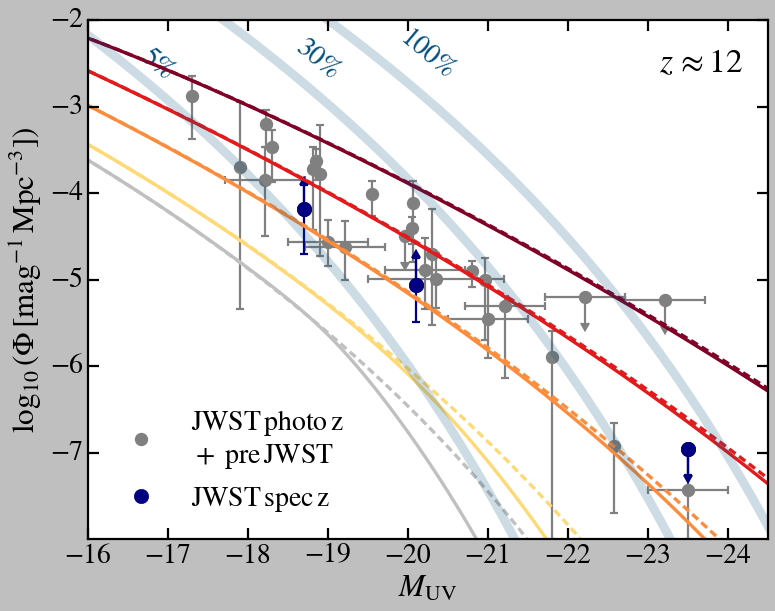

In [167]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 12
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=8, Mmax=17, dlog10m = mass_resolution, cosmo=cosmo)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default
for i, sigma in enumerate([0.75, 1.5, 2, 2.5]):
    magshift = 0 #compute_mean_shift(sigma)
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, include_dust=False)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3, linestyle="--", dashes=(7,4))

    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3)

# no scatter case 
muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)                  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))

muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3)

kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm JWST\,photo\,z$" + '\n' + r"$\rm +\,\,pre\,JWST$", **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)
plt.errorbar([],[], label=r"$\rm JWST\,spec\,z$", **kwargs)

##
for epsilon, color in zip([0.05, 0.3, 1],
                          ["#034e7b","#034e7b","#034e7b"]):
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                          sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)     
    plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2) 
             #label=r"$\sigma_{\rm UV} = {%.0f},\,\,\epsilon={%d}\%%$" % (0, epsilon*100))
    id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]
    if muv_arr[id] + 0.1 < -16.5:
        plt.text( muv_arr[id] + 0.1, np.log10(phi_uv_arr[id]), f"{epsilon*100:.0f}%", fontsize=25, color=color, rotation=-40, zorder=-1)

#plt.plot([],[],'--', c='gray', lw=1.5, label=r"$\rm no\,\,dust$")
#plt.plot([],[],'-' , c='gray', lw=1.5, label=r"$\rm with\,\,dust$")

leg = plt.legend(fontsize=25, loc=3, frameon=True, framealpha=1, numpoints=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\,\approx{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/3670193854.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/3670193854.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3, label=r"$\sigma_{\rm UV} = 0$")
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/3670193854.py:43: RuntimeWarning: divide by zero encountered in log10
  plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2)
/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/3670193854.py:45: RuntimeWarning: divide by zero encountered in log10
  id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]


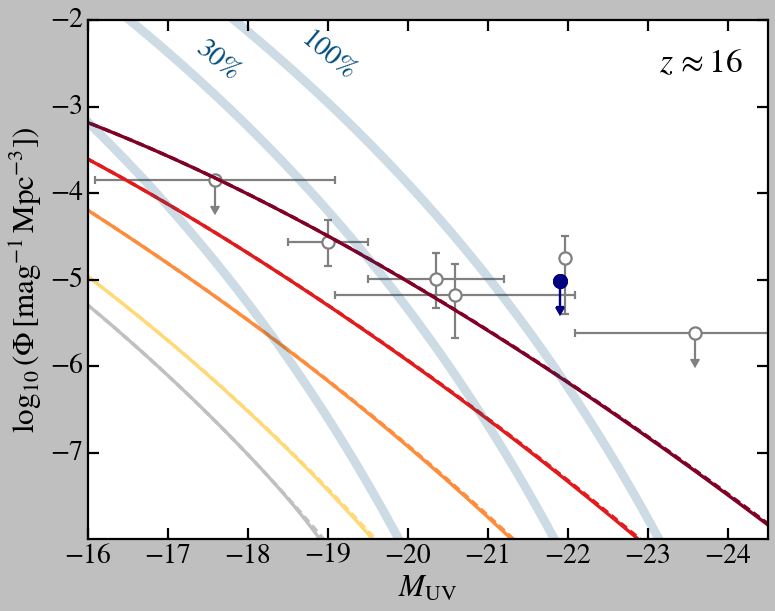

In [166]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.81])

redshift = 16
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=8, Mmax=15, dlog10m = mass_resolution, cosmo=cosmo)
epsilon = "this_work" #"H22_z7" 

colors = colorlist_default
for i, sigma in enumerate([0.75, 1.5, 2.0, 2.5]):
    magshift = 0 #compute_mean_shift(sigma)
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, include_dust=False)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3, linestyle="--", dashes=(7,4))

    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)                          
    plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color=colors[i], lw=3, label=r"$\sigma_{\rm UV} = %.1f$" % sigma)

# no scatter case 
muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)                  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color='silver', alpha=1, lw=3, linestyle="--", dashes=(7,4))

muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                    sigma_uv = 0, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)  
plt.plot(muv_arr + magshift, np.log10(phi_uv_arr), color="silver", alpha=1, lw=3, label=r"$\sigma_{\rm UV} = 0$")


kwargs = {"ms": 11,  "color": "gray", "mec": "gray", "mfc": "white", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_photoz_constraints(redshift=redshift, ax=ax, **kwargs)

kwargs = {"ms": 13,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 4, "lw": 2, "capthick": 2, "alpha": 1, "zorder": -8}
plot_specz_constraints(redshift=redshift, ax=ax, **kwargs)

##
for epsilon, color in zip([0.05, 0.3, 1],
                          ["#034e7b","#034e7b","#034e7b"]):
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                          sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)     
    plt.plot( muv_arr, np.log10(phi_uv_arr), '-', color=color, lw=8, alpha=0.2) 
             #label=r"$\sigma_{\rm UV} = {%.0f},\,\,\epsilon={%d}\%%$" % (0, epsilon*100))
    id = np.arange(len(muv_arr))[np.log10(phi_uv_arr) > -2.7][-1]
    if muv_arr[id] + 0.1 < -16:
        plt.text( muv_arr[id] + 0.1, np.log10(phi_uv_arr[id]), f"{epsilon*100:.0f}%", fontsize=25, color=color, rotation=-40, zorder=-1)

plt.plot([],[],'--', c='gray', lw=1.5, label=r"$\rm no\,\,dust$")
plt.plot([],[],'-' , c='gray', lw=1.5, label=r"$\rm with\,\,dust$")

#leg = plt.legend(fontsize=16, loc=3, frameon=True, framealpha=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M_{\rm UV}$', fontsize=28)
plt.ylabel(r"$\log_{10}{(\Phi\,[{\rm mag}^{-1}\, {\rm Mpc}^{-3}])}$", fontsize=28)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z\,\approx{redshift}$", fontsize=30, transform = plt.gca().transAxes)

plt.xlim(-16, -24.5); plt.ylim(-7.99, -2); plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/uvlf_vary_sigma_z={redshift}.pdf")

In [43]:
def compute_sigma_uv():
    sigma_halo_accretion = 0.3  * 2.5
    sigma_epsilon = 0.5 * 2.5
    sigma_dust    = 0.5  # A_lamb = 1.086 * tau_lamb

    sigma_uv_min = np.sqrt(sigma_halo_accretion**2 + sigma_epsilon**2 + sigma_dust**2)
    sigma_uv_max = sigma_halo_accretion + sigma_epsilon + sigma_dust
    return sigma_uv_min, sigma_uv_max

print(compute_sigma_uv())

(1.541103500742244, 2.5)


/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/1722439869.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.plot(muv_arr, np.log10(count_arr), color=colors[i], lw=3, label=r"$\sigma_{\rm UV} = %.2f$" % sigma)


-29.972332212722584 1.0836403033788429


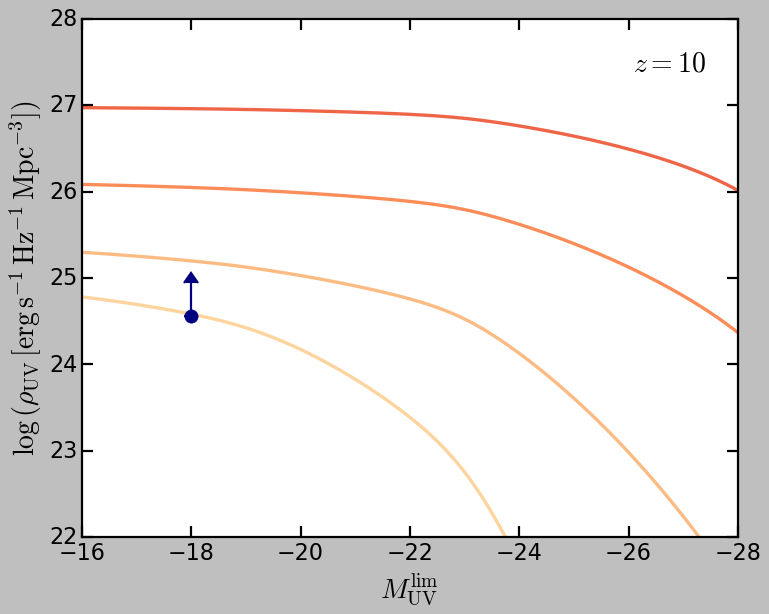

In [44]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.82, 0.81])

redshift = 10
mass_resolution = 0.01 
mhalo_arr, phi_halo_arr = calculate_hmf(z=redshift, Mmin=7, Mmax=18, dlog10m = mass_resolution, cosmo=cosmo)
epsilon = "H22_z7" 


colors = ["#fdd49e", "#fdbb84", "#fc8d59", "#ef6548", "#d7301f", "#990000"]
for i, sigma in enumerate([0.75, 1.5, 2.25, 3]):
    #muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
    #                                sigma_uv = sigma, epsilon=epsilon, redshift=redshift, include_dust=False)    
    #count_arr = compute_cumulative_uv_luminosity(muv_arr, phi_uv_arr)
    #plt.plot(muv_arr, np.log10(count_arr), color=colors[i], lw=3, linestyle="--", dashes=(7,4))

    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)    
    count_arr = compute_cumulative_uv_luminosity(muv_arr, phi_uv_arr, mlim_lum=-29.5)       
    plt.plot(muv_arr, np.log10(count_arr), color=colors[i], lw=3, label=r"$\sigma_{\rm UV} = %.2f$" % sigma)

print(np.min(muv_arr), np.max(muv_arr))
##
'''
for epsilon, color in zip([0.05, 0.3, 1],
                          ["#034e7b","#034e7b","#034e7b"]):
    muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                          sigma_uv = 0, epsilon=epsilon, redshift=redshift, include_dust=False)  
    count_arr = compute_cumulative_uv_luminosity(muv_arr, phi_uv_arr)      
    plt.plot( muv_arr, np.log10(count_arr), '-', color=color, lw=8, alpha=0.1) 
             #label=r"$\sigma_{\rm UV} = {%.0f},\,\,\epsilon={%d}\%%$" % (0, epsilon*100))
    id = np.arange(len(muv_arr))[muv_arr > -18][-1]
    plt.text( muv_arr[id], np.log10(count_arr[id])-0.2, f"{epsilon*100:.0f}%", fontsize=20, color=color, rotation=-22, zorder=-1)
'''
kwargs = {"ms": 12,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 6, "lw": 2, "capthick": 2}
if redshift==10:
    plt.errorbar( -18, 24.56, yerr=([0.39],[0.38]), lolims=True, **kwargs )
elif redshift==12:
    plt.errorbar( -18, 24.35, yerr=([0.31],[0.23]), lolims=True, **kwargs )  

#leg = plt.legend(fontsize=18, loc=3, ncol=2, frameon=True, framealpha=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$M^{\rm lim}_{\rm UV}$', fontsize=25)
plt.ylabel(r"$\log{(\rho_{\rm UV}\,[{\rm erg}\,{\rm s}^{-1}\, {\rm Hz}^{-1}\,{\rm Mpc}^{-3}])}$", fontsize=25)
# set the tick size of the x-axis and y-axis
plt.text(0.84, 0.9, rf"$z={redshift}$", fontsize=25, transform = plt.gca().transAxes)

plt.xlim(-16, -28); plt.ylim(22, 28) #plt.ylim(-8, -2); 
plt.gca().tick_params(labelsize=20, size=10)
plt.savefig(f"figures/rho_uv_vary_sigma_z={redshift}.pdf")

## UV luminosity density versus redshift

In [65]:
redshift_array = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
sigma_uv_array = [0.75, 1.5, 2.0, 2.5]

active = False
if active:
    rhouv_array = np.zeros((len(sigma_uv_array), len(redshift_array), 2))
    for i , redshift in enumerate(redshift_array):
        mass_resolution = 0.01 
        mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=7, Mmax=17, dlog10m = mass_resolution, cosmo=cosmo)
        epsilon = "this_work" #"H22_z7" 
        for j, sigma_uv in enumerate(sigma_uv_array):
            muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                                    sigma_uv = sigma_uv, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)    
            sel = muv_arr > -18
            rhouv_array[j,i,0] = compute_cumulative_uv_luminosity(muv_arr, phi_uv_arr)[sel][-1]    

            sel = muv_arr > -17
            rhouv_array[j,i,1] = compute_cumulative_uv_luminosity(muv_arr, phi_uv_arr)[sel][-1]    
    
        print(i, np.min(muv_arr))

In [66]:
if active: np.save("rhouv_vs_redshift.npy", rhouv_array)
else:
    rhouv_array = np.load("rhouv_vs_redshift.npy")

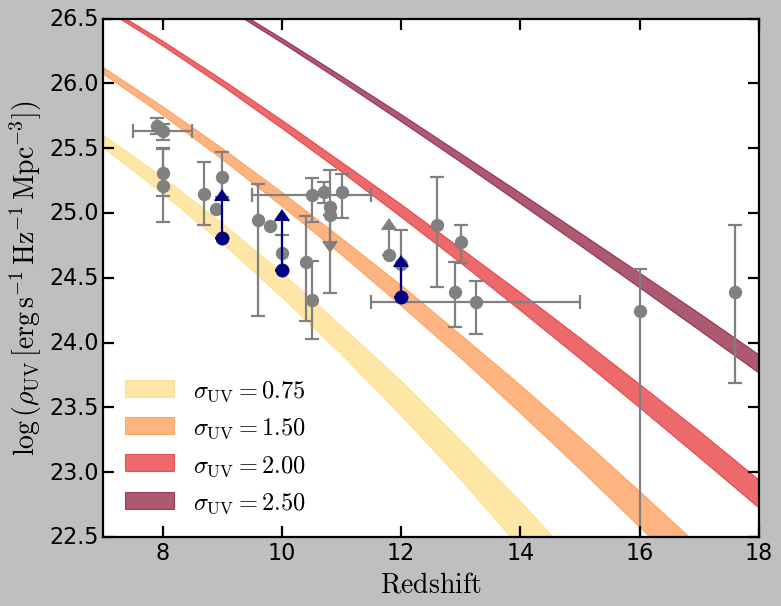

In [67]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.12, 0.12, 0.82, 0.81])

colors = colorlist_default
for i in range(len(sigma_uv_array)):
    plt.fill_between(redshift_array, np.log10(rhouv_array[i,:,0]), np.log10(rhouv_array[i,:,1]), 
                     color=colors[i], edgecolor=colors[i], alpha=0.65, label=r"$\sigma_{\rm UV} = %.2f$" % sigma_uv_array[i])

#leg = plt.legend(fontsize=16, loc=3, ncol=2, frameon=True, framealpha=1); leg.get_frame().set_linewidth(0)
plt.xlabel(r'$\rm Redshift$', fontsize=25)
plt.ylabel(r"$\log{(\rho_{\rm UV}\,[{\rm erg}\,{\rm s}^{-1}\, {\rm Hz}^{-1}\,{\rm Mpc}^{-3}])}$", fontsize=25)
# set the tick size of the x-axis and y-axis
#plt.text(0.84, 0.9, rf"$z={redshift}$", fontsize=25, transform = plt.gca().transAxes)

# observations
kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 6, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": 1}
basepath = "./observational_data/UVLD/"
######
f = np.genfromtxt(basepath+"UVLD_data_typelog.dat", names=True)
ax.errorbar(f["z"], f["log_rhouv"], yerr=(f["lo"],f["up"]), **kwargs)
######
f = np.genfromtxt(basepath+"UVLD_data_digit.dat", names=True)
x = f["z"]; y=f["log_rhouv"]; yup = f["up"]; ylo = f["lo"]
ax.errorbar(x, y, xerr=(x-f["left"],f["right"]-x), yerr=((y-ylo),(yup-y)), **kwargs)
######
f = np.genfromtxt(basepath+"UVLD_data_Coe2013.dat", names=True)
x = f["z"]; y=np.log10(f["rhosfr"]*8e27); 
yup = np.log10((f["rhosfr"]+f["up"])*8e27); ylo = np.log10((f["rhosfr"]-f["lo"])*8e27)
ax.errorbar(x, y, yerr=((y-ylo),(yup-y)), **kwargs)
######
f = np.genfromtxt(basepath+"UVLD_data_Ellis2013.dat", names=True)
sel = f["type"] == 0
x = f["z"][sel]; y=np.log10(f["rhouv"][sel])
ax.errorbar(x, y, **kwargs)
sel = f["type"] == 1
x = f["z"][sel]; y=np.log10(f["rhouv"][sel])
ax.errorbar(x, y, yerr=(np.zeros(len(y)),0.2*np.ones(len(x))), lolims=True, **kwargs)
sel = f["type"] == 2
x = f["z"][sel]; y=np.log10(f["rhouv"][sel])
ax.errorbar(x, y, yerr=(0.2*np.ones(len(x)), np.zeros(len(y))), uplims=True, **kwargs)


kwargs = {"ms": 12,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 6, "lw": 2, "capthick": 2, "alpha": 1, "zorder": 2}
plt.errorbar( [9,10,12], [24.81, 24.56, 24.35], yerr=([0.42, 0.39, 0.31],[0.28, 0.38, 0.23]), 
             lolims=True, **kwargs )

plt.xlim(7, 18); plt.ylim(22.5, 26.5) #plt.ylim(-8, -2); 
plt.legend(loc=3, frameon=False, fontsize=22)
plt.gca().tick_params(labelsize=20, size=10)
plt.savefig(f"figures/rhouv_redshift.pdf")

## constraints in the parameter space

In [68]:
# benchmark  

# constraints that defines a model "work"
constraints = {
    "photo": {
        10: (-20.5, -4.7),
        12: (-20.5, -5.0),
        16: (-20.5, -5.2),
    },
    "spec": {
        10: (-20.5, -5.0),
        12: (-20.5, -5.3),
        16: (-20.5, -np.inf)
    }
}


def search_grid_point( epsilon_corr, sigma_uv ):
    pass_photo_noz16 = True
    pass_photo = True
    pass_spec  = True
    for redshift in [10, 12, 16]:
        mass_resolution = 0.01 
        mhalo_arr, phi_halo_arr = calculate_hmf_kmaxextra(z=redshift, Mmin=8, Mmax=16, dlog10m = mass_resolution, cosmo=cosmo)
        epsilon = f"vary_{epsilon_corr}" 

        #print(epsilon)
        muv_arr, phi_uv_arr = compute_uv_luminosity_function(mhalo_arr, phi_halo_arr, 
                              sigma_uv = sigma_uv, epsilon=epsilon, redshift=redshift, dust_norm="fixed", include_dust=True)                          
        if pass_photo_noz16 & (redshift != 16):
            select = muv_arr < constraints["photo"][redshift][0]
            if np.log10(phi_uv_arr)[select][0] < constraints["photo"][redshift][1]:
                pass_photo_noz16 = False
        
        if pass_photo:
            select = muv_arr < constraints["photo"][redshift][0]
            if np.log10(phi_uv_arr)[select][0] < constraints["photo"][redshift][1]:
                pass_photo = False
    
        if pass_spec:
            select = muv_arr < constraints["spec"][redshift][0]
            if np.log10(phi_uv_arr)[select][0] < constraints["spec"][redshift][1]:
                pass_spec = False
    
    return pass_photo, pass_spec, pass_photo_noz16


In [69]:
epsilon_corr_grid = np.logspace(np.log10(0.3), np.log10(8), 40)
sigma_uv_grid     = np.linspace(3.5 ,0, 40)

active = False
if active:
    pass_photo_grid = np.zeros(len(epsilon_corr_grid))
    pass_photo_noz16_grid = np.zeros(len(epsilon_corr_grid))
    pass_spec_grid  = np.zeros(len(epsilon_corr_grid))

    jstart = 0
    for i in range(len(epsilon_corr_grid)):
        print(i)
        jstart_changed = False
        for j in range(jstart, len(sigma_uv_grid)):
            pass_photo, pass_spec, pass_photo_noz16 =  search_grid_point( epsilon_corr_grid[i], sigma_uv_grid[j] )
            if (not pass_photo) and (pass_photo_grid[i]==0): 
                pass_photo_grid[i] = sigma_uv_grid[j]
            if (not pass_spec) and (pass_spec_grid[i]==0):
                pass_spec_grid[i]  = sigma_uv_grid[j]
            if (not pass_photo_noz16) and (pass_photo_noz16_grid[i]==0):
                pass_photo_noz16_grid[i]  = sigma_uv_grid[j]

            if (not pass_spec) or (not pass_photo) or (not pass_photo_noz16):
                if (not jstart_changed): 
                    jstart = j; jstart_changed = True
            #print(pass_photo, pass_spec, j, jstart, jstart_changed)
            if (not pass_spec) and (not pass_photo) and (not pass_photo_noz16):
                break

In [70]:
if active:
    np.save("pass_photo_grid.npy", pass_photo_grid)
    np.save("pass_spec_grid.npy", pass_spec_grid)
    np.save("pass_photo_noz16_grid.npy", pass_photo_noz16_grid)
else:
    pass_photo_grid = np.load("pass_photo_grid.npy")
    pass_spec_grid  = np.load("pass_spec_grid.npy")
    pass_photo_noz16_grid = np.load("pass_photo_noz16_grid.npy")

In [71]:
from scipy.signal import savgol_filter

/var/folders/86/n8hxl7g53vb4b3d7pt1xwnm80000gq/T/ipykernel_26732/1012693949.py:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(0.87, 0.75, '.', marker='_', markersize=12, mew=3, color="chocolate")


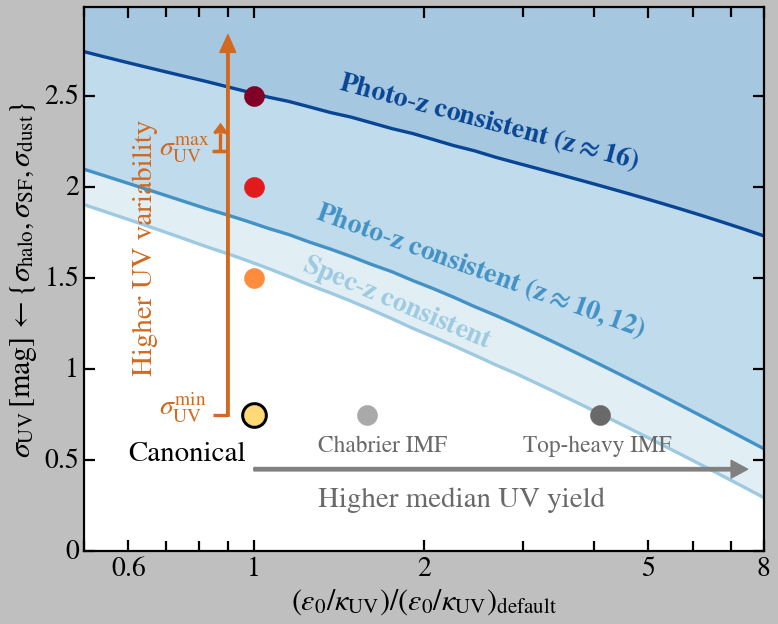

In [169]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.11, 0.12, 0.85, 0.85])

# plot as step
color_pspace = ["#9ecae1", "#4292c6", "#084594"] 

yphoto = savgol_filter(pass_photo_grid, window_length=25, polyorder=3) # window size 51, polynomial order 3
plt.plot(epsilon_corr_grid, yphoto, lw=3, color=color_pspace[2])
#plt.step(epsilon_corr_grid, pass_photo_grid, where='mid', lw=1, linestyle='--', color="crimson")

yphoto_noz16 = savgol_filter(pass_photo_noz16_grid, window_length=25, polyorder=3) # window size 51, polynomial order 3
plt.plot(epsilon_corr_grid, yphoto_noz16, lw=3, color=color_pspace[1])
#plt.step(epsilon_corr_grid, pass_photo_noz16_grid, where='mid', lw=1, linestyle='--', color="crimson")

yspec = savgol_filter(pass_spec_grid, window_length=25, polyorder=3)
plt.plot(epsilon_corr_grid, yspec, lw=3, color=color_pspace[0])
#plt.step(epsilon_corr_grid, pass_spec_grid, where='mid', lw=1, linestyle='--', color="royalblue")

y2 = np.ones(len(epsilon_corr_grid)) * 5
plt.fill_between(epsilon_corr_grid, y1=yphoto      , y2=y2, color=color_pspace[2], alpha=0.2)
plt.fill_between(epsilon_corr_grid, y1=yphoto_noz16, y2=y2, color=color_pspace[1], alpha=0.25)
plt.fill_between(epsilon_corr_grid, y1=yspec       , y2=y2, color=color_pspace[0], alpha=0.3)

plt.text(1.2, 1.12, r"$\rm \bf Spec$-$\rm \bf z\,\,consistent$", fontsize=25, 
         color=color_pspace[0], rotation=-23)
plt.text(1.27, 1.18, r"$\rm \bf Photo$-$\rm \bf z\,\,consistent\,\,(z\approx 10,12)$", fontsize=25, 
         color=color_pspace[1], rotation=-20)
plt.text(1.4, 2.1, r"$\rm \bf Photo$-$\rm \bf z\,\,consistent\,\,(z\approx 16)$", fontsize=25, 
         color=color_pspace[2], rotation=-15)

plt.plot(1, 0.75, marker="o", color=colorlist_default[0], mec="k", mew=5, ms=19)
for i, sigma_uv in enumerate([0.75, 1.5, 2.0, 2.5]):
    plt.plot(1, sigma_uv, marker="o", color=colorlist_default[i], mec=colorlist_default[i], ms=18)

plt.plot(3.57/(1/1.15), 0.75, marker="o", color="dimgray", mec="dimgray", ms=18)
plt.plot(1/0.63, 0.75 , marker="o"      , color="darkgray", mec="darkgray", ms=18)

plt.text(0.6, 0.5, "Canonical", fontsize=26, color="k")
plt.arrow(0.9, 0.74, 0, 2.0, width=0.01, head_width=0.06, head_length=0.1, fc='chocolate', ec='chocolate', zorder=10)
plt.arrow(1.0, 0.45, 6, 0  , width=0.02, head_width=0.1 , head_length=0.5, fc='gray', ec='gray', zorder=10)

plt.text(1.3, 0.25,  "Higher median UV yield", fontsize=26, color="dimgray", zorder=10)
plt.text(1.3, 0.55, "Chabrier IMF" , fontsize=21, color="dimgray", zorder=10)
plt.text(3.0, 0.55, "Top-heavy IMF", fontsize=21, color="dimgray", zorder=10)
plt.text(0.61, 1.0, "Higher UV variability", fontsize=26, color="chocolate", rotation=90, zorder=10)
plt.text(0.68, 0.75, r"$\sigma^{\rm min}_{\rm UV}$", fontsize=25, color="chocolate", rotation=0)
plt.text(0.68, 2.18, r"$\sigma^{\rm max}_{\rm UV}$", fontsize=25, color="chocolate", rotation=0)

ax.plot(0.87, 0.75, '.', marker='_', markersize=12, mew=3, color="chocolate")
ax.errorbar(0.87, 2.2, yerr=([0],[0.1]), marker='_', markersize=15, mew=3, lw=3, capsize=5, lolims=True, color="chocolate")

plt.xscale("log")
plt.xlabel(r"$(\epsilon_{0}/\kappa_{\rm UV}) / (\epsilon_{0}/\kappa_{\rm UV})_{\rm default}$", fontsize=27)
plt.ylabel(r"$\sigma_{\rm UV}\,[{\rm mag}]\, \leftarrow \{\sigma_{\rm halo}, \sigma_{\rm SF}, \sigma_{\rm dust}\}$", fontsize=27)
plt.xlim(0.5, np.max(epsilon_corr_grid)); plt.ylim(0, 2.99)
# set the xticks manually
plt.xticks([0.6, 1, 2, 5, 8], ["0.6","1", "2", "5", "8"])
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5], ["0", "0.5","1", "1.5", "2", "2.5"])

plt.gca().tick_params(labelsize=25, size=10)
plt.savefig(f"figures/parameter_space.pdf")

## Integrate the UV lum density to get stellar mass density

In [73]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
import astropy.units as u

redshift_array = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
redshift_array_edge = [5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]
rhouv_array = np.load("rhouv_vs_redshift.npy")

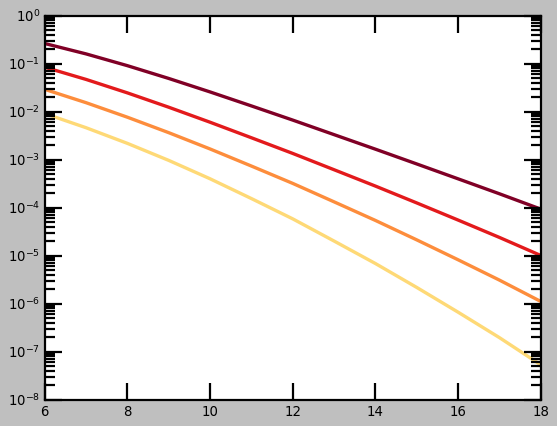

In [74]:
for i in range(4):
    sfrd = rhouv_array[i,:,1] * 1.15e-28 # [Msun/yr/Mpc^3]
    plt.plot(redshift_array, sfrd, lw=3, color=colorlist_default[i])
plt.yscale('log')

In [75]:
redshift_array[10], redshift_array[3]

(16, 9)

In [76]:
fitting_functions = []
fitting_functions_lower = []

# sigma_uv = [0.75, 1.5, 2.0, 2.5]
for i in range(4):
    sfrd = rhouv_array[i,:,1] * 1.15e-28 # [Msun/yr/Mpc^3]
    fitting_functions.append( interp1d(redshift_array, np.log10(sfrd), kind='linear', fill_value='extrapolate') )

    sfrd = rhouv_array[i,:,0] * 1.15e-28 # [Msun/yr/Mpc^3]
    fitting_functions_lower.append( interp1d(redshift_array, np.log10(sfrd), kind='linear', fill_value='extrapolate') )

log_redshift = np.log10(1 + np.array(redshift_array))

interpolate_function = interp1d( np.array([log_redshift[3], log_redshift[11]]), 
                                 np.array([np.log10(1.15e-28 * rhouv_array[0,3,1]), np.log10(1.15e-28 * rhouv_array[3,11,1])]), 
                                 kind='linear', fill_value='extrapolate')
interpolate_function_lower = interp1d( np.array([log_redshift[3], log_redshift[11]]), 
                                       np.array([np.log10(1.15e-28 * rhouv_array[0,3,0]), np.log10(1.15e-28 * rhouv_array[3,11,0])]), 
                                       kind='linear', fill_value='extrapolate')

'''
def connected_fitting_function(z):
    S0 = fitting_functions[0](z)
    S1 = fitting_functions[1](z)
    S2 = fitting_functions[2](z)
    S3 = fitting_functions[3](z)
    return 0.5*(S0 * (z < 10) + S1 * (z<10)) + S1 * (z >= 10) * (z < 13) \
        + S2 * (z >= 13) * (z < 15) + S3 * (z >= 15)
def connected_fitting_function_lower(z):
    S0 = fitting_functions_lower[0](z)
    S1 = fitting_functions_lower[1](z)
    S2 = fitting_functions_lower[2](z)
    S3 = fitting_functions_lower[3](z)
    return 0.5*(S0 * (z < 10) + S1 * (z<10)) + S1 * (z >= 10) * (z < 13) \
        + S2 * (z >= 13) * (z < 15) + S3 * (z >= 15)
'''

def connected_fitting_function(z):
    zbreak = 10.0
    S0 = fitting_functions[0](z)
    S1 = fitting_functions[1](z)
    S2 = interpolate_function( np.log10(1+z) ) + 0.04
    return 0.5 * (S0 + S1) * (z < zbreak) + S2 * (z >= zbreak) 

def connected_fitting_function_lower(z):
    zbreak = 10.0
    S0 = fitting_functions_lower[0](z)
    S1 = fitting_functions_lower[1](z)
    S2 = interpolate_function_lower( np.log10(1+z) ) + 0.04
    return 0.5 * (S0 + S1) * (z < zbreak) + S2 * (z >= zbreak) 


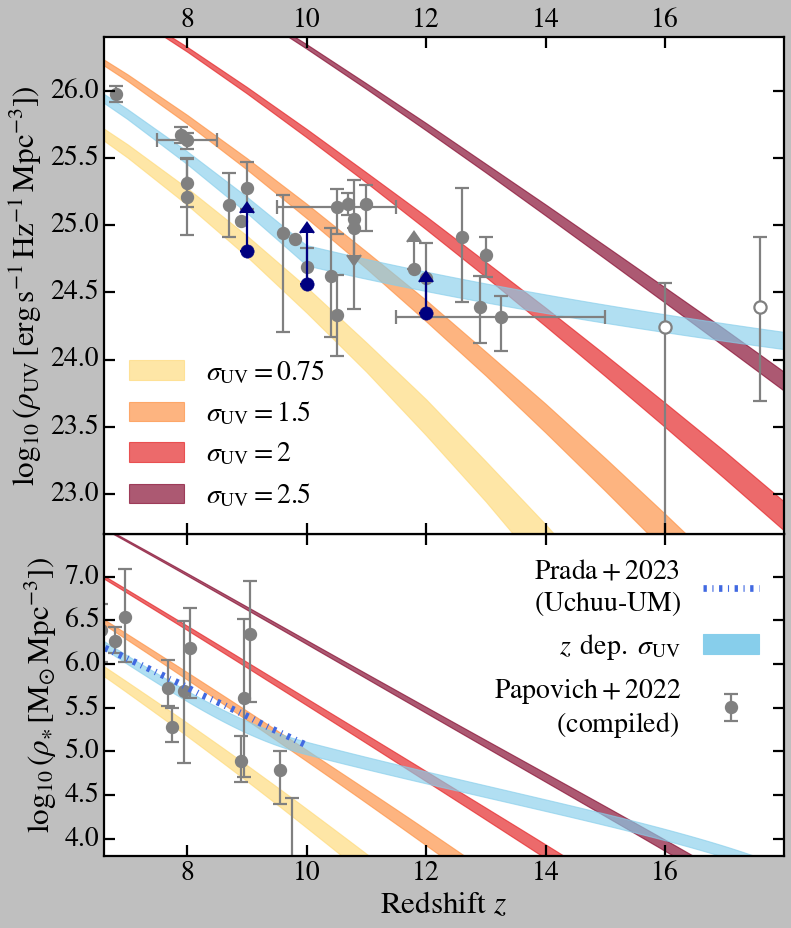

In [168]:
# a combined plot

fig = plt.figure(figsize=(10, 11.5))
#ax1 = fig.add_axes([0.12, 0.07, 0.82, 0.56])
#ax2 = fig.add_axes([0.12, 0.63, 0.82, 0.35])
ax1 = fig.add_axes([0.12, 0.07, 0.85, 0.35])
ax2 = fig.add_axes([0.12, 0.42, 0.85, 0.54])

colors = colorlist_default
for i in range(len(sigma_uv_array)):
    if i == 0: label=r"$\sigma_{\rm UV} = %.2f$" % sigma_uv_array[i]
    elif i == 2: label=r"$\sigma_{\rm UV} = %d$" % sigma_uv_array[i]
    else: label=r"$\sigma_{\rm UV} = %.1f$" % sigma_uv_array[i]
    ax2.fill_between(redshift_array, np.log10(rhouv_array[i,:,0]), np.log10(rhouv_array[i,:,1]), 
                     color=colors[i], edgecolor=colors[i], alpha=0.65, label=label)

redshift_refined_edge = np.linspace(6, 20, 1001)
ax2.fill_between(redshift_refined_edge, 
                 y1 = connected_fitting_function_lower(redshift_refined_edge) - np.log10(1.15e-28),
                 y2 = connected_fitting_function(redshift_refined_edge) - np.log10(1.15e-28),
                 color='skyblue', edgecolor="skyblue", alpha=0.65)

# observations
kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 6, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": 1}
kwargs_open = {"ms": 11,  "color": "gray", "mec": "gray", "mfc": "white", "marker": "o", "linestyle": "none",
          "capsize": 6, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": 1}
basepath = "./observational_data/UVLD/"
######
f = np.genfromtxt(basepath+"UVLD_data_typelog.dat", names=True)
sel = f["z"] < 14
ax2.errorbar(f["z"][sel], f["log_rhouv"][sel], yerr=(f["lo"][sel],f["up"][sel]), **kwargs)
sel = f["z"] > 14
ax2.errorbar(f["z"][sel], f["log_rhouv"][sel], yerr=(f["lo"][sel],f["up"][sel]), **kwargs_open)
######
f = np.genfromtxt(basepath+"UVLD_data_digit.dat", names=True)
x = f["z"]; y=f["log_rhouv"]; yup = f["up"]; ylo = f["lo"]
ax2.errorbar(x, y, xerr=(x-f["left"],f["right"]-x), yerr=((y-ylo),(yup-y)), **kwargs)
######
f = np.genfromtxt(basepath+"UVLD_data_Coe2013.dat", names=True)
x = f["z"]; y=np.log10(f["rhosfr"]*8e27); 
yup = np.log10((f["rhosfr"]+f["up"])*8e27); ylo = np.log10((f["rhosfr"]-f["lo"])*8e27)
ax2.errorbar(x, y, yerr=((y-ylo),(yup-y)), **kwargs)
######
f = np.genfromtxt(basepath+"UVLD_data_Ellis2013.dat", names=True)
sel = f["type"] == 0
x = f["z"][sel]; y=np.log10(f["rhouv"][sel])
ax2.errorbar(x, y, **kwargs)
sel = f["type"] == 1
x = f["z"][sel]; y=np.log10(f["rhouv"][sel])
ax2.errorbar(x, y, yerr=(np.zeros(len(y)),0.2*np.ones(len(x))), lolims=True, **kwargs)
sel = f["type"] == 2
x = f["z"][sel]; y=np.log10(f["rhouv"][sel])
ax2.errorbar(x, y, yerr=(0.2*np.ones(len(x)), np.zeros(len(y))), uplims=True, **kwargs)


kwargs = {"ms": 12,  "color": "navy", "mec": "navy", "mfc": "navy", "marker": "o", "linestyle": "none",
          "capsize": 6, "lw": 2, "capthick": 2, "alpha": 1, "zorder": 2}
ax2.errorbar( [9,10,12], [24.81, 24.56, 24.35], yerr=([0.42, 0.39, 0.31],[0.28, 0.38, 0.23]), 
             lolims=True, **kwargs )

#ax2 
redshift_refined_edge = np.linspace(6, 20, 1001)
redshift_refined = (redshift_refined_edge[1:] + redshift_refined_edge[:-1]) / 2
time_refined = cosmo.age(redshift_refined_edge).value * 1e9 # [yr]
delta_time = - (time_refined[1:] - time_refined[:-1]) # [yr]

for i in range(4):
    sfrd = 10**fitting_functions[i](redshift_refined) # [Msun/yr/Mpc^3]
    smd = np.cumsum((delta_time * sfrd)[::-1])[::-1]

    sfrd = 10**fitting_functions_lower[i](redshift_refined) # [Msun/yr/Mpc^3]
    smd_lower = np.cumsum((delta_time * sfrd)[::-1])[::-1]

    ax1.fill_between(redshift_refined, np.log10(smd_lower), np.log10(smd), color=colors[i], edgecolor=colors[i], alpha=0.65)

sfrd = 10**connected_fitting_function(redshift_refined) # [Msun/yr/Mpc^3]
smd = np.cumsum((delta_time * sfrd)[::-1])[::-1]
sfrd = 10**connected_fitting_function_lower(redshift_refined) # [Msun/yr/Mpc^3]
smd_lower = np.cumsum((delta_time * sfrd)[::-1])[::-1]
ax1.fill_between(redshift_refined, np.log10(smd_lower), np.log10(smd), color="skyblue", edgecolor="skyblue", alpha=0.65)

# observations
kwargs = {"ms": 10,  "color": "gray", "mec": "gray", "mfc": "gray", "marker": "o", "linestyle": "none",
          "capsize": 6, "lw": 2, "mew": 2, "capthick": 2, "alpha": 1, "zorder": 1}
f = np.genfromtxt("./observational_data/SMD/Papovich2022_digit.dat", names=True)
l1 = ax1.errorbar(f["z"], f["rho"], yerr=[f["rho"] - f["lo"], f["up"] - f["rho"]], label=r"$\rm Papovich+2022$"+'\n'+r"         $\rm (compiled)$", **kwargs)

# simulations
f = np.genfromtxt("./observational_data/SMD/UchuuUM-sim-digit.dat", names=True)
l2, = ax1.plot(f["z"], f["rho"], '-.', lw=6, color='royalblue', zorder= 2, label=r"$\rm Prada+2023$" + '\n' + r"$(\rm Uchuu$-$\rm UM)$")

l3 = ax1.fill_between([], [], [], color="skyblue", edgecolor="skyblue", label=r"$\rm {\it z}\,\,\, dep.$ $\sigma_{\rm UV}$")

# ticks, labels 
ax1.set_xlabel(r'$\rm Redshift$ $z$', fontsize=28)
ax1.set_ylabel(r"$\log_{10}{(\rho_{\ast}\,[{\rm M}_{\odot}\,{\rm Mpc}^{-3}])}$", fontsize=28)
ax1.set_xlim(6.6, 17.99); ax1.set_ylim(3.8, 7.49) 
ax1.legend(loc=1, frameon=False, fontsize=25, numpoints=1, ncol=1, markerfirst=False)
ax1.tick_params(labelsize=25, size=10)

ax2.set_ylabel(r"$\log_{10}{(\rho_{\rm UV}\,[{\rm erg}\,{\rm s}^{-1}\, {\rm Hz}^{-1}\,{\rm Mpc}^{-3}])}$", fontsize=28)
ax2.set_xlim(6.6, 17.99); 
ax2.set_ylim(22.7, 26.4) #plt.ylim(-8, -2); 
ax2.tick_params(axis='x', labelsize=25, size=10, labeltop=True, labelbottom=False)
ax2.tick_params(axis='y', labelsize=25, size=10)
ax2.legend(loc=3, frameon=False, fontsize=25)
#ax2.add_artist(plt.legend(handles=[l3], bbox_to_anchor=(0.6, 1), loc=1, frameon=False, fontsize=22, numpoints=1, ncol=1))
#ax2.add_artist(plt.legend(handles=[l1, l2], bbox_to_anchor=(1, 1), loc=1, frameon=False, fontsize=22, numpoints=1, ncol=1))

plt.savefig(f"figures/rhouv+smd_redshift.pdf")